In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BTC-USD.csv to BTC-USD.csv


In [ ]:
import io
import pandas as pd
#Bitcoin data is from 17th Sept, 2014 to 15th May, 2021 sourced from Yahoo Finance
df_BTC = pd.read_csv(io.BytesIO(uploaded['BTC-USD.csv']))
df_BTC.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
##Importing neccesary libraries
##Reference code - https://curiousily.com/posts/cryptocurrency-price-prediction-in-tensorflow-2/

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
df_BTC.shape



(2433, 7)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 8 Text major ticklabel objects>)

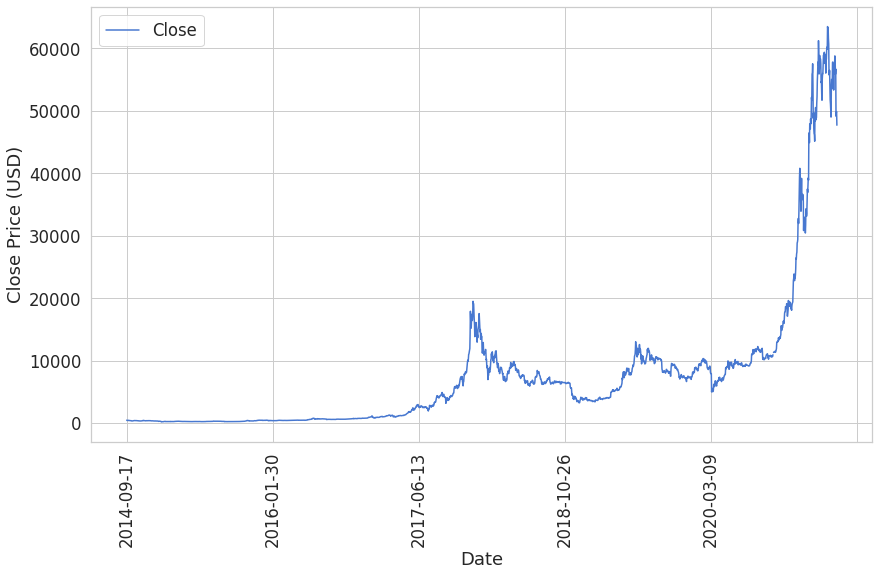

In [ ]:
ax = df_BTC.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
plt.xticks(rotation=90)

##Data Pre-processing

In [ ]:
#Since our data is not normalized, and we are using LSTM models that would need the values to be in between [0,1]
#Our model is based on RNN with LSTM layers which uses Sigmoid Activation Function to transform input vectors to vectors 
#with entries that have value in a range of [0,1]. Therefore, we use normalization to scale model features given 
#that the denominator will always be larger than the nominator, the output value will always be a number between 0 and 1.

#First, we’re going to squish our price data in the range [0, 1]. Recall that this will help our optimization algorithm converge faster:

In [ ]:
scaler = MinMaxScaler()

#The scaler expects the data to be shaped as (x, y), so we add a dummy dimension using reshape before applying it.
#Add close column of BTC's values to close_price after reshaping
close_price = df_BTC.Close.values.reshape(-1, 1)
#^Here we added another dummy dimension as tranformation works only after that
scaled_close = scaler.fit_transform(close_price)
#^Here we transformed the close prices to normalize them


In [ ]:
##Next step, let us remove the NaN values

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
#Tilda is for negation
#Here also we used 'numpy is NaN' to remove the numerical NaN values from the data frame, 

scaled_close = scaled_close.reshape(-1, 1)
#Reshaping after removing the NaN's again.


In [ ]:
#So ~np.NaN simply meant to filter in the values which are not missing

In [ ]:
scaled_close.shape
#Checking shape of new df

(2429, 1)

In [ ]:
np.isnan(scaled_close).any()
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

#Pre-processing
##Defining sequences for training and testing

LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is:
[batch_size, sequence_length, n_features]



In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])


##Num train is 95% of data

#:Numtrain means from starting to 95% of data
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]


#Numtrain: means start after 95% of data
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)



In [ ]:
X_test.shape

(117, 99, 1)

In [ ]:
X_train.shape

(2212, 99, 1)

In [ ]:
#Model
#Bidirectional RNNs allows you to train on the sequence data in forward and backward (reversed) direction.
#CuDNNLSTM is a “Fast LSTM implementation backed by cuDNN”

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))



In [ ]:
#Training
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

#In the next step, we had to go to 'Runtime', Change Runtime - to GPU and run everything again.

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
32/32 [==============================] - 15s 189ms/step - loss: 0.0030 - val_loss: 0.0117
Epoch 2/50
32/32 [==============================] - 5s 150ms/step - loss: 0.0040 - val_loss: 0.0152
Epoch 3/50
32/32 [==============================] - 5s 150ms/step - loss: 0.0020 - val_loss: 0.0095
Epoch 4/50
32/32 [==============================] - 5s 149ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 5/50
32/32 [==============================] - 5s 150ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/50
32/32 [==============================] - 5s 148ms/step - loss: 7.9518e-04 - val_loss: 8.5631e-04
Epoch 7/50
32/32 [==============================] - 5s 150ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 8/50
32/32 [==============================] - 5s 151ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 9/50
32/32 [==============================] - 5s 150ms/step - loss: 0.0034 - val_loss: 0.0108
Epoch 10/50
32/32 [==============================] - 5s 150ms/step - loss: 0.0014 - val_los

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 100ms/step - loss: 0.0031


0.003104077884927392

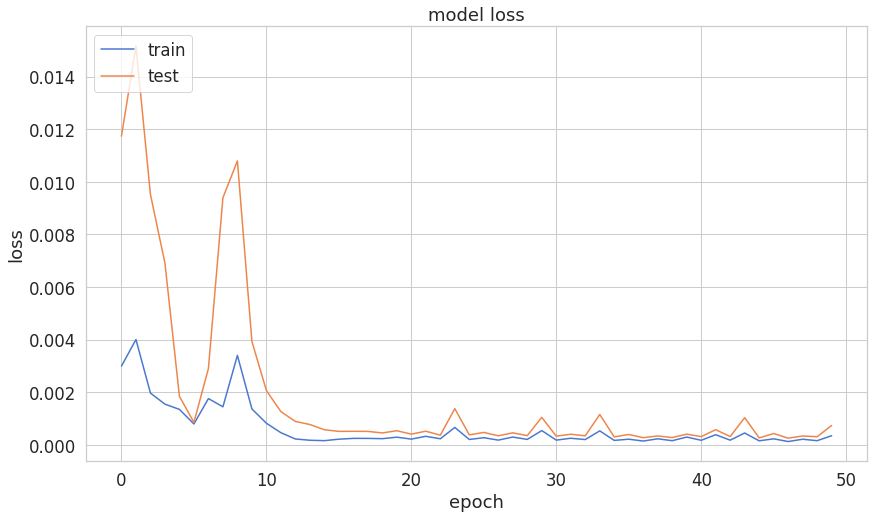

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

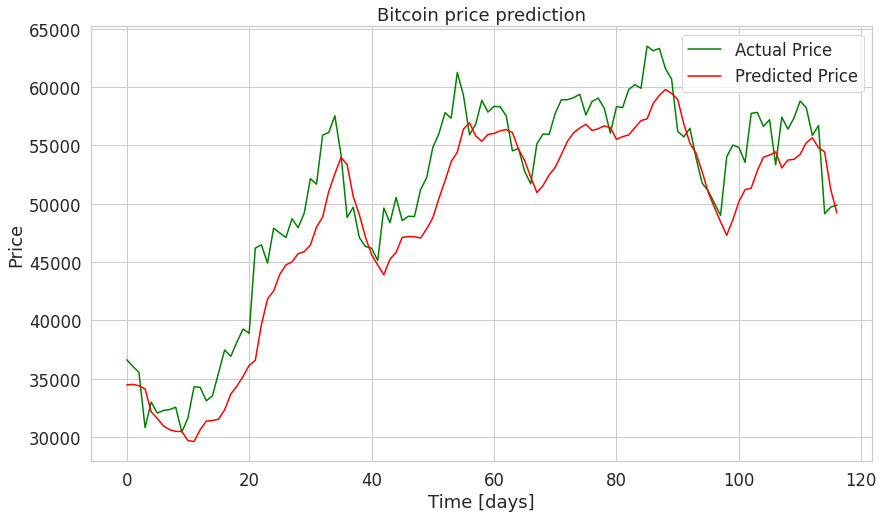

In [ ]:
#Prediction
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [ ]:
#Another approach to specify the training and testing data set

In [ ]:
#To divide in 80-20
#n_train_rows = int(df_BTC.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
#train = dataset.iloc[:n_train_rows, :]
#test = dataset.iloc[n_train_rows:, :]#

Checking accuracy of methods

In [ ]:
from sklearn.metrics import mean_absolute_error
rf_val_mae = mean_absolute_error(y_test_inverse,y_hat_inverse)  #  "Actual Price"  , "Predicted Price"
rf_val_mae

2967.93352707158

In [ ]:
rmse = np.sqrt(((y_hat_inverse - y_test_inverse) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 3528.12


MAE is telling us that on average, our bitcoin price prediction is off by $3679.70 from the actual prices.

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test_inverse, y_hat_inverse)

0.8395718745088385